In [1]:
import numpy as np
from neuralStellar2 import *
import pymc3 as pm
import corner
import seaborn as sns
import theano.tensor as T
import theano
import os
import pandas as pd
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [4]:
m1=NNmodel('evo',['mass','age','feh','MLT'],['radius','Teff','delnu'], Teff_scaling=5000)
m1.loadModel('Ran_files/big_grid_77/000_best_model.h5')

Model: "neuralstellar"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 5)]               0         
_________________________________________________________________
dense_77 (Dense)             (None, 128)               768       
_________________________________________________________________
dense_78 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_79 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_80 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_81 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_82 (Dense)             (None, 128)             

In [22]:
df = pd.read_csv('grid2_trun.csv')

In [109]:
solar_df = df[df['initial_feh']==0.0]
solar_df = solar_df[solar_df['initial_Yinit']==0.28]
solar_df = solar_df[solar_df['initial_MLT']==1.9]

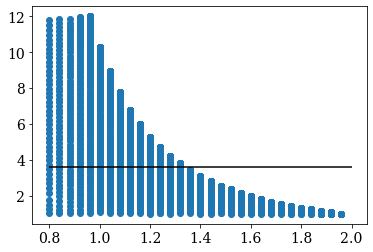

In [113]:
plt.scatter(solar_df['initial_mass'],solar_df['star_age'])
plt.hlines(3.6,0.8,2.0)
plt.show()

# Create the pseudo-cluster data from NN

In [23]:
age_population = [3.6, 0.1]
feh_population = [0,0.0]
Y_population = [0.28,0.00]
N = 500

Dmass = np.random.rand(int(N))*(1.3-0.8)+0.8
Dage = np.random.randn(N)*age_population[1]+age_population[0]
Dfeh = np.random.randn(N)*feh_population[1]+feh_population[0]
DY = np.random.randn(N)*Y_population[1]+Y_population[0]
DMLT = np.ones(N)*1.9

mfrac=0.4
Dinputs = np.array([Dmass,Dage,Dfeh,DY,DMLT]).T
Tinputs = []
Toutputs = []
for star in Dinputs:
    #candidates = df.iloc[(df['initial_MLT']-star[4]).abs().argsort()[:1000]]
    candidates = df[df['initial_MLT'].between(star[4]-0.1,star[4]+0.1)]
    candidates = candidates[candidates['initial_Yinit'].between(star[3]-0.01,star[3]+0.01)]
    candidates = candidates[candidates['star_feh'].between(star[2]-0.1,star[2]+0.1)]
    candidates = candidates[candidates['star_mass'].between(star[0]-mfrac,star[0]+mfrac)]
    this_mfrac = mfrac
    while len(candidates.index)>5000:
        this_mfrac=this_mfrac/4
        new_candidates = candidates[candidates['star_mass'].between(star[0]-this_mfrac,star[0]+this_mfrac)]
        if len(new_candidates.index)>0:
            candidates = new_candidates
        else: break
    #candidates = candidates[candidates['star_age'].between(star[1])]
    selected = candidates.iloc[(candidates['star_age']-star[1]).abs().argsort()[:1]]
    inputs = selected[['star_mass','star_age','star_feh','initial_Yinit','initial_MLT']].values[0]
    if abs(inputs[0]-star[0])<0.05 and abs(inputs[1]-star[1])<0.5:
        Tinputs.append(inputs)
        outputs = selected[['luminosity','effective_T','delta_nu']].values[0]
        Toutputs.append(outputs)
N=len(Tinputs)
print(N)
Tinputs=np.array(Tinputs).T
Toutputs=np.array(Toutputs).T
[Tmass, Tage, Tfeh, TY, TMLT] = Tinputs
[TL, TTeff, Tdelnu] = Toutputs

Noutputs = m1.model.predict(np.log10([Tmass, Tage, 10**Tfeh, TY, TMLT]).T).T
[Nrad, NTeff, Ndelnu] = 10**Noutputs
NTeff = NTeff*5000
NL = Nrad**2*(NTeff/5776.02970722)**4

Doutputs = m1.model.predict(np.log10([Dmass, Dage, 10**Dfeh, DY, DMLT]).T).T
[Drad, DTeff, Ddelnu] = 10**Doutputs
DTeff = DTeff*5000
DL = Drad**2*(DTeff/5776.02970722)**4

408


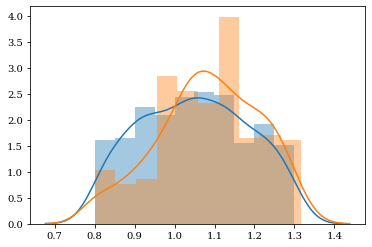

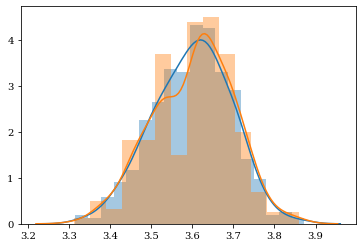

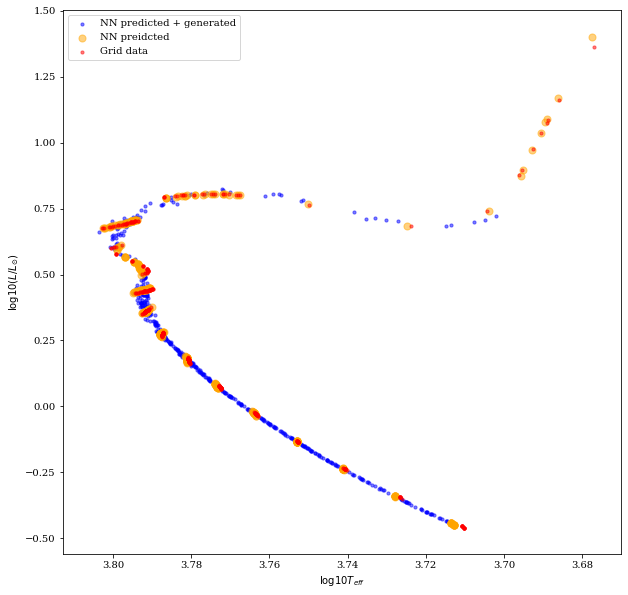

In [25]:
sns.distplot(Dmass)
sns.distplot(Tmass)
plt.show()
sns.distplot(Dage)
sns.distplot(Tage)
plt.show()

points = df[:100000]
fig, ax=plt.subplots(1,1, figsize=(10,10))
ax.scatter(np.log10(DTeff), np.log10(DL), s=10, zorder=2, c='blue', alpha=0.5, label='NN predicted + generated')
ax.scatter(np.log10(NTeff), np.log10(NL), s=50, zorder=2, c='orange', alpha=0.5, label='NN preidcted')
ax.scatter(np.log10(TTeff), np.log10(TL), s=10, zorder=2, c='red', alpha=0.5, label='Grid data')
#ax.scatter(np.log10(points['effective_T']),np.log10(points['luminosity']),s=5,zorder=1,c='gray',alpha=0.2,label='All data')
ax.set_xlim(ax.get_xlim()[::-1])
ax.set_xlabel(r'$\log10 T_{eff}$')
ax.set_ylabel(r'$\log10(L/L_{\odot})$')
ax.legend()
plt.show()

100


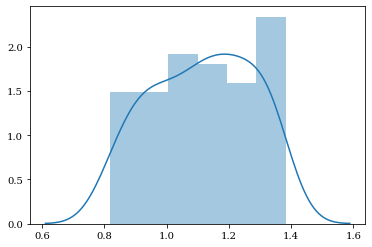

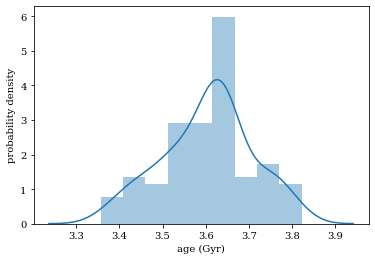

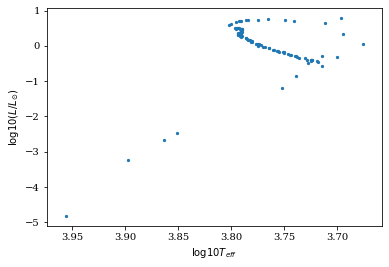

In [11]:
age_population = [3.6, 0.1]
feh_population = [0,0.0]
Y_population = [0.28,0.01]
N = 100
Tmass = np.random.rand(int(N))*(1.40-0.8)+0.8
#Tmass_pre = -np.random.lognormal(1,0.43,N)*(0.59/8)+1.37
#Tmass1 = Tmass_pre[Tmass_pre>0.8]
#Tmass = Tmass1[Tmass1<1.4]
#Tmass = Tmass_pre
print(len(Tmass))
sns.distplot(Tmass)
plt.show()
N = len(Tmass)

Tage = np.random.randn(N)*age_population[1]+age_population[0]
#Tage = -np.random.lognormal(1,0.4,N)*(age_population[1]/1.5)+(age_population[0]+0.2)
sns.distplot(Tage)
plt.xlabel('age (Gyr)')
#plt.xlim([0,10])
plt.ylabel('probability density')
plt.show()

Tfeh = np.random.randn(N)*feh_population[1]+feh_population[0]
TY = np.random.randn(N)*Y_population[1]+Y_population[0]
TMLT = np.ones(N)*1.9

Tinputs = np.log10(np.vstack((Tmass, Tage, 10**Tfeh, TY, TMLT)))
Toutputs = m1.model.predict(Tinputs.T).T
[Trad, TTeff, Tdelnu] = 10**Toutputs
TTeff = TTeff*5000
TL = Trad**2*(TTeff/5942.261537)**4
fig, ax=plt.subplots(1,1)
ax.scatter(np.log10(TTeff), np.log10(TL), s=5)
ax.set_xlim(ax.get_xlim()[::-1])
ax.set_xlabel(r'$\log10 T_{eff}$')
ax.set_ylabel(r'$\log10(L/L_{\odot})$')
plt.show()

# HBM!!

In [97]:
m1.manualPredict1(theano.shared(np.array([[1,2],[1,2],[1,2],[1,2],[1,2]]))).eval()

array([[-6.02732645e+08, -1.28096485e+09],
       [-6.65932374e+07, -1.41535156e+08],
       [-1.22932843e+09, -2.61276246e+09]])

In [17]:
model = pm.Model()
with model:
    Age_mu = pm.Deterministic('mean_age',pm.Beta('a',1.1,1.1)*(0.5*2)+(3.6-0.5))
    Age_sigma = pm.Bound(pm.Lognormal, lower=0, upper=0.3)('spread_age', T.log(0.1), 0.1)
    Age = pm.Normal('age', Age_mu, Age_sigma, shape=N)
    #Age = pm.Deterministic('age',pm.Beta('b',1.5,1.5,shape=N)*2*Age_sigma+(Age_mu-Age_sigma))
    M = pm.Deterministic('mass', pm.Beta('c',1.1,1.1,shape=N)*(1.3-0.8)+0.8)
    feh = pm.Deterministic('feh', T.zeros(N))
    #Y_mu = pm.Bound(pm.Normal, lower=0.27, upper=0.29)('mean_Y', 0.28, 0.005)
    #Y_sigma = pm.Bound(pm.Lognormal, lower=0, upper=0.03)('spread_Y', T.log(0.01), 0.05)
    #Y = pm.Normal('Y', Y_mu, Y_sigma, shape=N)
    #Y = pm.Deterministic('Y',pm.Beta('d',1.5,1.5,shape=N)*2*Y_sigma+(Y_mu-Y_sigma))
    Y = pm.Deterministic('Y',T.ones(N)*0.28)
    MLT = pm.Deterministic('MLT',T.ones(N)*1.9)
    
    obs = pm.Deterministic('obs',m1.manualPredict(T.log10([M, Age, 10**feh, Y, MLT])))
    
    true_Teff = pm.Deterministic('true_Teff', 10**obs[1,:]*5000)
    true_L = pm.Deterministic('true_L', (10**obs[0,:])**2*(true_Teff/5776.02970722)**4)
    obs_L = pm.Normal('obs_L',true_L,0.1, observed=TL)
    obs_Teff = pm.Normal('obs_Teff',true_Teff,70, observed=TTeff)
    obs_delnu = pm.Normal('obs_delnu',10**obs[2,:],0.1, observed=Tdelnu)

In [104]:
start = {'mean_age':3.6, 'spread_age':0.1, 'mean_Y':0.28, 'spread_Y':0.01}
with model:
    trace = pm.sample(tune=5000, init='adapt_diag', start=start, target_accept=0.99, cores=1, chains=2)
    #mean_field = pm.fit(n=50000, method='advi')
    #advi = pm.ADVI()

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [Y, spread_Y, mean_Y, c, age, spread_age, mean_age]


ValueError: Mass matrix contains zeros on the diagonal. 
The derivative of RV `spread_Y_log__`.ravel()[0] is zero.
The derivative of RV `age`.ravel()[18] is zero.
The derivative of RV `age`.ravel()[31] is zero.
The derivative of RV `age`.ravel()[78] is zero.
The derivative of RV `age`.ravel()[82] is zero.
The derivative of RV `age`.ravel()[89] is zero.
The derivative of RV `age`.ravel()[98] is zero.

In [86]:
file = 'pymc3_traces/NNcluster2'
os.mkdir(file)
pm.save_trace(trace, directory=file+'/', overwrite=True)

FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'pymc3_traces/NNcluster1'

In [18]:
trace = pm.load_trace(directory='pymc3_traces/NNcluster3', model=model)

In [19]:
pm.summary(trace)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
age[0],3.541,0.231,3.089,3.947,0.018,0.013,169.0,169.0,167.0,324.0,1.01
age[1],3.543,0.226,3.115,3.961,0.018,0.012,165.0,165.0,162.0,286.0,1.01
age[2],3.539,0.228,3.129,3.943,0.017,0.012,183.0,183.0,181.0,302.0,1.01
age[3],3.549,0.228,3.127,3.985,0.017,0.012,175.0,175.0,173.0,307.0,1.01
age[4],3.550,0.209,3.151,3.928,0.016,0.011,175.0,175.0,174.0,230.0,1.01
a,0.443,0.210,0.054,0.820,0.017,0.012,161.0,161.0,156.0,234.0,1.01
mean_age,3.543,0.210,3.154,3.920,0.017,0.012,161.0,161.0,156.0,234.0,1.01
spread_age,0.100,0.010,0.082,0.119,0.000,0.000,407.0,407.0,408.0,504.0,1.00
c[0],0.231,0.008,0.217,0.248,0.001,0.000,170.0,169.0,170.0,349.0,1.01
c[1],0.221,0.008,0.208,0.237,0.001,0.000,165.0,165.0,164.0,285.0,1.01


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000025D8F9E9400>,
      dtype=object)

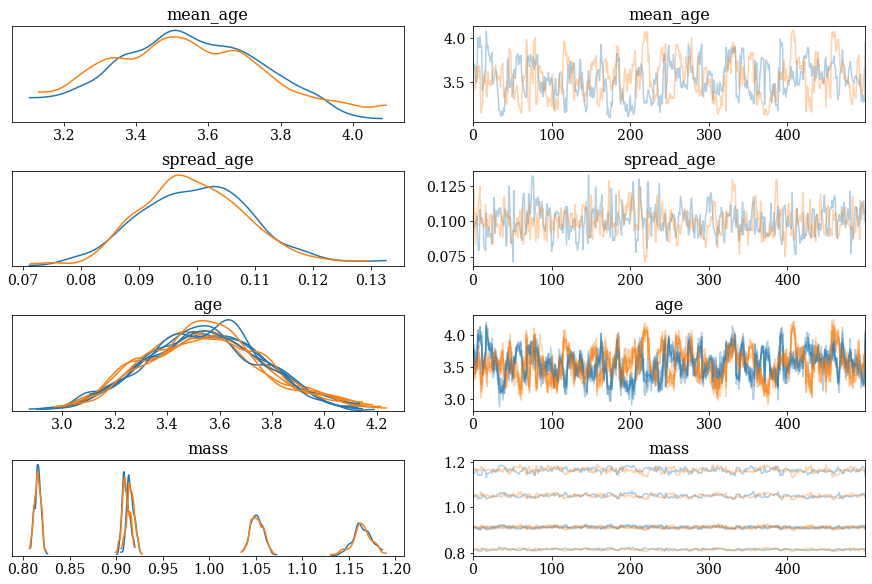

In [20]:
pm.plots.traceplot(trace,var_names=['mean_age','spread_age','age','mass'],compact=True)

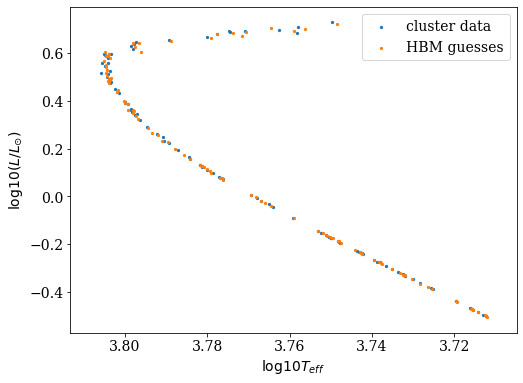

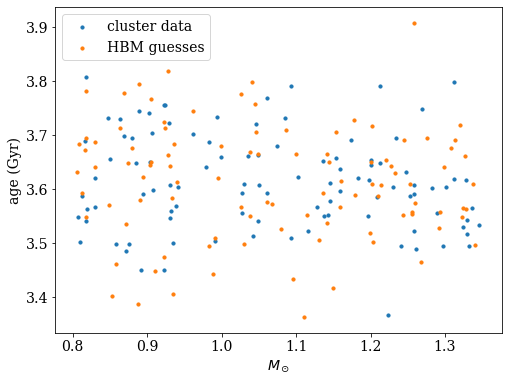

In [100]:
from matplotlib import rc
rc("font", family="serif", size=14)
pop1_ages=trace['age'][0]
pop1_masses = trace['mass'][0]
Finputs = np.log10(np.vstack((pop1_masses, pop1_ages, 10**Tfeh, 10**TMLT)))
Foutputs = m1.model.predict(Finputs.T).T
[FL, FTeff, Fdelnu] = 10**Foutputs
fig, ax=plt.subplots(1,1,figsize=[8,6])
ax.scatter(np.log10(TTeff), np.log10(TL), s=5, label='cluster data')
ax.scatter(np.log10(FTeff), np.log10(FL), s=5, label='HBM guesses')
ax.set_xlim(ax.get_xlim()[::-1])
ax.set_xlabel(r'$\log10 T_{eff}$')
ax.set_ylabel(r'$\log10(L/L_{\odot})$')
ax.legend()
plt.show()

fig, ax=plt.subplots(1,1,figsize=[8,6])
ax.scatter(Tmass, Tage,s=10, label='cluster data')
ax.scatter(pop1_masses, pop1_ages, s=10, label='HBM guesses')
#ax.scatter(mean_masses, np.random.randn(N)*np.mean(trace['spread_age'])+np.mean(trace['mean_age']),s=10)
ax.set_xlabel(r'$M_\odot$')
ax.set_ylabel(r'age (Gyr)')
ax.legend()
plt.show()

In [71]:
pm.summary(trace, var_names=['mean_age','spread_age','age','mass'])

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mean_age,3.582,0.029,3.528,3.636,0.004,0.003,46.0,46.0,47.0,121.0,1.04
spread_age,0.093,0.009,0.078,0.110,0.001,0.000,301.0,300.0,307.0,487.0,1.00
age[0],3.586,0.086,3.424,3.741,0.003,0.002,864.0,853.0,853.0,718.0,1.00
age[1],3.582,0.093,3.400,3.739,0.004,0.003,519.0,511.0,574.0,640.0,1.01
age[2],3.580,0.104,3.392,3.772,0.004,0.003,579.0,576.0,565.0,719.0,1.00
age[3],3.581,0.100,3.398,3.767,0.004,0.003,620.0,620.0,617.0,598.0,1.00
age[4],3.581,0.094,3.409,3.754,0.004,0.003,589.0,581.0,580.0,872.0,1.00
age[5],3.564,0.087,3.383,3.715,0.003,0.002,678.0,678.0,676.0,878.0,1.00
age[6],3.582,0.096,3.398,3.751,0.004,0.003,516.0,516.0,508.0,826.0,1.00
age[7],3.577,0.084,3.419,3.729,0.003,0.002,823.0,823.0,817.0,772.0,1.00
